In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from scipy.integrate import simps
%matplotlib inline
%precision 3

'%.3f'

In [2]:
ex2data2 = np.loadtxt("data/ex2data2.txt", delimiter=",")

exam_1_score = ex2data2[:, 0]

exam_1_score = ex2data2[:, 0]
exam_2_score = ex2data2[:, 1]

X = ex2data2[:, :-1]
y = ex2data2[:, -1]
exam_2_score = ex2data2[:, 1]

X = ex2data2[:, :-1]
y = ex2data2[:, -1]

In [3]:
class RLogisticRegression:

    def __init__(self,
                 X,
                 y,
                 alfa=0.001,
                 num_iter=100000,
                 fit_intercept=True,
                 weights_to_initialise=0):

        self.X = X
        self.y = y.reshape(len(y), 1)

        self._fit_intercept = fit_intercept
        self._alfa = alfa
        self._num_iter = num_iter
        self._m = X.shape[0]
        self._n = (X.shape[1] + 1) if fit_intercept else X.shape[1]

        self.thetas = None
        
        self._add_constant()
        self._initalise_θ(weights_to_initialise)


    def _add_constant(self):
        if self._fit_intercept:
            constants = np.ones((self._m, 1))
            self.X = np.concatenate((constants, self.X), axis=1)


    def _initalise_θ(self, weight_to_initialise):
        self.thetas = np.zeros(
            self._n
        ) + weight_to_initialise


    def _sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))


    def _h(self):
        z = (self.X @ self.thetas.reshape(-1, 1))
        return self._sigmoid(z)


    def _calculate_cost(self, LAMBDA):
        epsilon = 1e-5 # to silence the "RuntimeWarning: divide by zero encountered in log" errors
        h = self._h()
        regularisation = (LAMBDA / self._m * 2) * np.sum(np.square(self.thetas[1:]))

        return np.mean(-1 * (
            (self.y) * np.log(h + epsilon)
            + (1 - self.y) * np.log(1 - h + epsilon)  
        )) + regularisation


    def _gradient(self, LAMBDA):
        h = self._h()
        regularisation = (LAMBDA / self._m) * self.thetas[1:]
        regularisation_theta_0_added = np.insert(regularisation, 0, 0, axis=0).reshape(self._n, 1)
        
        gradient = (1 / self._m) * self.X.T @ (h - self.y) + regularisation_theta_0_added
        return gradient.flatten()


    def fit(self, LAMBDA=1, verbose=False):
        print("COST: {}".format(self._calculate_cost(LAMBDA=LAMBDA)))
        print(self.thetas)
        for i in range(self._num_iter):
            self.thetas -= self._alfa * self._gradient(LAMBDA=LAMBDA)
            if (i % 50000 == 0):
                print("COST: {}".format(self._calculate_cost(LAMBDA=LAMBDA)))
                if verbose:
                    print(self.thetas)


    def predict_prob(self):
        return self._sigmoid(self.X @ self.thetas)


    def predict_prob_single_instance(self, index):
        prob_matrix = self._sigmoid(self.X @ self.thetas)
        
        exam_scores = "Exam Score 1: %.3f\nExam Score 2: %.3f" % (self.X[index, 1], self.X[index, 2])
        probability = "Probability of Being Admitted: %.2f%%" % (prob_matrix[index] * 100)
        print(exam_scores); print(probability)


    def predict(self, threshold=0.5):
        prediction = self.predict_prob()
        prediction[prediction > threshold] = 1
        prediction[prediction <= threshold] = 0
        return prediction

In [4]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);


def calculate_model_performance(actual, predicted):
    TP = 0; TN = 0; FP = 0; FN = 0

    for act, pred in zip(actual, predicted):
        if act == 1:
            if act == pred:    TP += 1
            else:              FN += 1
        else:
            if act == pred:    TN += 1
            else:              FP += 1

    def specificity():
        return TN / (TN + FP) * 100

    def sensitivity_recall():
        return TP / (TP + FN) * 100

    def accuracy():
        return (TP + TN) / (TP + TN + FP + FN) * 100

    def prevalence():
        return (TP + FN) / (TP + TN + FP + FN) * 100

    def precision():
        return TP / (TP + FP) * 100
    
    def false_positive():
        return FP / (FP + TN) * 100
    
    def F1():
        return (2 * (
                (precision() * sensitivity_recall())
                / (precision() + sensitivity_recall())
            ))

    model_metrics = {
        "specificty": specificity(),
        "sensitivity/recall": sensitivity_recall(),
        "accuracy": accuracy(),
        "prevalence": prevalence(),
        "precision": precision(),
        "F1": F1(),
        "false_positive_rate": false_positive()
    }
    return model_metrics


def plot_ROC(
    RLogReg_instance,
    threshold_spacing=50,
    verbose=False
):
    false_positive_rate = []
    true_positive_rate = []
    actual = RLogReg_instance.y

    for threshold in np.linspace(0, 0.95, threshold_spacing):
        predicted = RLogReg_instance.predict(threshold)
        model_metrics = calculate_model_performance(actual, predicted)
        false_positive_rate.append(model_metrics["false_positive_rate"])
        true_positive_rate.append(model_metrics["sensitivity/recall"])
        if verbose:
            print("Threshold: %.3f \nF1:%s\n" %(threshold, model_metrics["F1"]))
            
    #Here we multiply with -1 because recall is in decreasing order and therefore,
    #np.trapz returns a negative value. However, taking the integral of an equation
    #should return us the area under a curve which cannot be negative.
    AUC = -1 * np.trapz(y=true_positive_rate, x=false_positive_rate) 
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 100], [0, 100])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # AUC is divided by 100 here because in calculate_model_performance function,
    # these metrics are multiplied by 100
    plt.title("ROC Curve - AUC %.3f" %(AUC/100)) 
    plt.legend(["Logistic Regression", "Random guess"], loc='lower right');


def calculate_decision_boundary_values(coefficients, X):
    x1 = X[:, 1]
    x2 = (-1 / coefficients[2]) * (coefficients[0] + coefficients[1] * x1)
    return x1, x2


def plot_decision_boundary(coefficients, X):
    x1, x2 = calculate_decision_boundary_values(coefficients, X)
    plt.plot(x1,x2,'r-',label='Decision Boundary');


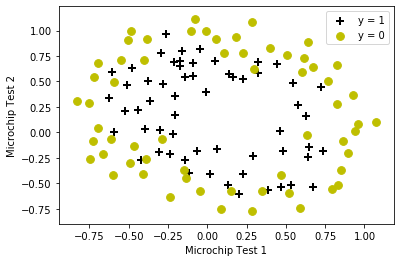

In [5]:
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [6]:
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X)

In [7]:
# LAMBDA 1
# COST: 0.6123004121966032
# [ 5.41873718e-01  8.15689394e-02  4.44733168e-01 -8.58393639e-01
#  -2.58049951e-01 -4.78806310e-01 -8.96596604e-02 -1.19484116e-01
#  -1.27027966e-01 -1.66617683e-01 -6.73534367e-01 -2.86055214e-02
#  -2.34906880e-01 -6.60561186e-02 -5.50170050e-01 -2.06797391e-01
#  -7.87061617e-02 -3.99384067e-02 -1.01469022e-01 -8.78571394e-02
#  -3.52644832e-01 -5.10746788e-01 -5.00221792e-03 -1.18833681e-01
#  -6.85807850e-04 -1.30317401e-01 -2.90675602e-02 -5.35642401e-01]

# LAMBDA 0.5
# COST: 0.5744751405183768
# [ 8.81537304e-01  3.35671221e-01  8.32893203e-01 -1.42281415e+00
#  -4.98526952e-01 -8.14863753e-01 -2.07809043e-02 -2.20282027e-01
#  -2.19482740e-01 -1.99188142e-01 -1.09391078e+00 -5.01465688e-02
#  -4.05943583e-01 -1.35126282e-01 -8.78106800e-01 -2.57371276e-01
#  -1.40830995e-01 -5.63667877e-02 -1.77559419e-01 -1.64491029e-01
#  -4.94644589e-01 -8.12694924e-01 -3.32089336e-03 -2.02963435e-01
#  -3.83179928e-04 -2.22178257e-01 -6.33609091e-02 -8.16097720e-01]

# LAMBDA 0.1
# COST: 0.4699577214240188
# [ 1.86395856  1.16508302  1.98304149 -3.06606528 -1.68430674 -2.15390219
#   0.3262334  -0.67036688 -0.62886034 -0.22663156 -2.32857998 -0.12929081
#  -1.01492937 -0.53779789 -1.90802507 -0.34306065 -0.38036578 -0.06835069
#  -0.48408633 -0.54731775 -0.71255162 -1.70764088  0.02274304 -0.48648496
#   0.00992452 -0.55205037 -0.30091823 -1.50750995]

# LAMBDA 0
# COST: 0.334673945570482
# [ 3.5080398   2.46926824  3.86962766 -5.23868756 -4.66377316 -5.71771698
#   1.17925608 -1.60257917 -0.72796692 -0.5006645  -4.42408228  0.64707117
#  -2.47593563 -1.8255301  -3.63869771 -0.75298571 -0.70275886  0.7903935
#  -1.5877627  -1.76426312  0.08455283 -3.66454125  0.57610037 -1.06033281
#   0.49043072 -1.56780282 -1.4681976  -1.39528306]

self = RLogisticRegression(X_poly,
                           y,
                           alfa=0.0003,
                           num_iter=10**7,
                           fit_intercept=False,
                           weights_to_initialise=0)

In [8]:
# LAMBDA 1
# self.thetas = [ 5.41873718e-01, 8.15689394e-02,  4.44733168e-01, -8.58393639e-01,
#   -2.58049951e-01, -4.78806310e-01, -8.96596604e-02, -1.19484116e-01,
#   -1.27027966e-01, -1.66617683e-01, -6.73534367e-01, -2.86055214e-02,
#   -2.34906880e-01, -6.60561186e-02, -5.50170050e-01, -2.06797391e-01,
#   -7.87061617e-02, -3.99384067e-02, -1.01469022e-01, -8.78571394e-02,
#   -3.52644832e-01, -5.10746788e-01, -5.00221792e-03, -1.18833681e-01,
#   -6.85807850e-04, -1.30317401e-01, -2.90675602e-02, -5.35642401e-01,]

# LAMBDA 0.5
# self.thetas = [8.81537304e-01,  3.35671221e-01,  8.32893203e-01, -1.42281415e+00,
#   -4.98526952e-01, -8.14863753e-01, -2.07809043e-02, -2.20282027e-01,
#   -2.19482740e-01, -1.99188142e-01, -1.09391078e+00, -5.01465688e-02,
#   -4.05943583e-01, -1.35126282e-01, -8.78106800e-01, -2.57371276e-01,
#   -1.40830995e-01, -5.63667877e-02, -1.77559419e-01, -1.64491029e-01,
#   -4.94644589e-01, -8.12694924e-01, -3.32089336e-03, -2.02963435e-01,
#   -3.83179928e-04, -2.22178257e-01, -6.33609091e-02, -8.16097720e-01,]

# LAMBDA 0.1
# self.thetas = [
# 1.86395856,  1.16508302,  1.98304149, -3.06606528, -1.68430674, -2.15390219,
# 0.3262334,  -0.67036688, -0.62886034, -0.22663156, -2.32857998, -0.12929081,
# -1.01492937, -0.53779789, -1.90802507, -0.34306065, -0.38036578, -0.06835069,
# -0.48408633, -0.54731775, -0.71255162, -1.70764088,  0.02274304, -0.48648496,
# 0.00992452, -0.55205037, -0.30091823, -1.50750995
# ]

# LAMBDA 0
# self.thetas = [
# 3.5080398,   2.46926824,  3.86962766, -5.23868756, -4.66377316, -5.71771698,
# 1.17925608, -1.60257917, -0.72796692, -0.5006645,  -4.42408228,  0.64707117,
# -2.47593563, -1.8255301,  -3.63869771, -0.75298571, -0.70275886,  0.7903935,
# -1.5877627,  -1.76426312,  0.08455283, -3.66454125,  0.57610037, -1.06033281,
# 0.49043072, -1.56780282, -1.4681976,  -1.39528306
# ]

#0.6931271807599428
#0.6931233407211389

In [ ]:
self.fit(LAMBDA=0, verbose=False)

COST: 0.6931271807599428
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
COST: 0.6931233407211389
COST: 0.6020610898068063
COST: 0.5542160996175354
COST: 0.5206543006770912
COST: 0.49547135711164064
COST: 0.47583154808284805
COST: 0.4600718386211779
COST: 0.44714001395951875
COST: 0.43633666145906463
COST: 0.42717811796947447
COST: 0.4193186361556912
COST: 0.4125040133482776
COST: 0.406542825437855
COST: 0.40128793846353034
COST: 0.39662424763703813
COST: 0.3924603170591417
COST: 0.38872253663159473
COST: 0.3853509475284213
COST: 0.3822962007661373
COST: 0.3795173022225811
COST: 0.3769799143692088
COST: 0.3746550591759143
COST: 0.3725181148050601
COST: 0.37054803062514174
COST: 0.36872670663195184
COST: 0.3670384981859971
COST: 0.3654698173313562
COST: 0.36400880930726304
COST: 0.3626450881472158
COST: 0.3613695191092569
COST: 0.36017403851830493
COST: 0.35905150371589156
COST: 0.3579955674046289
COST: 0.357000571884704
COST: 0.3560614596074233
CO

## Model performance measurement metrics

[The link can be found here - type .pdf](http://www.academicos.ccadet.unam.mx/jorge.marquez/cursos/Instrumentacion/FalsePositive_TrueNegative_etc.pdf)

[Another link for the confusion matrix - type .pdf](https://www.lexjansen.com/nesug/nesug10/hl/hl07.pdf)

[Metrics explained - Towards Data Science(TDS) Article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

[Metrics explained for non-technical - TDS Article](https://towardsdatascience.com/data-science-performance-metrics-for-everyone-4d68f4859eef)

In [ ]:
calculate_model_performance(self.y, self.predict(threshold=0.2))

In [ ]:
plot_ROC(RLogReg_instance=self)

In [ ]:
fig, axes = plt.subplots(1,1, sharey = True, figsize=(10,8))
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = self._sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(self.thetas))
h = h.reshape(xx1.shape)
axes.contour(xx1, xx2, h, [0.5], linewidths=2, colors='r');